# Optimizing Stixel Size

Yangkang Chen<br>
Sep 22, 2023

This notebook is to explore why and how we should tune the gridding hyperparameters of the Quadtree algorithm.

In [1]:

import pandas as pd
import numpy as np
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib
import warnings
import pickle
import os
import h3pandas
import time

# warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

## Download data

Please download the sample data from:<br>
- Mallard: https://figshare.com/articles/dataset/Sample_data_Mallard_csv/24080745<br>

Suppose now it's downloaded and saved as './Sample_data_Mallard.csv'<br>

Alternatively, you can try other species like <br>
- Alder Flycatcher: https://figshare.com/articles/dataset/Sample_data_Alder_Flycatcher_csv/24080751<br>
- Short-eared Owl: https://figshare.com/articles/dataset/Sample_data_Short-eared_Owl_csv/24080742<br>
- Eurasian Tree Sparrow: https://figshare.com/articles/dataset/Sample_data_Eurasian_Tree_Sparrow_csv/24080748<br>

**Caveat: These bird observation data are about 200MB each file.**

## Load data

In [4]:
data = pd.read_csv(f'./Sample_data_Mallard.csv')
data = data.drop('sampling_event_identifier', axis=1)


## Get X and y

In [5]:
X = data.drop('count', axis=1)
y = data['count'].values


## First thing first: Spatiotemporal train test split

In [6]:
from stemflow.model_selection import ST_train_test_split, ST_CV
CV = 5


## Train AdaSTEMRegressor with hurdle model as base model

In [7]:
from stemflow.model.AdaSTEM import AdaSTEM, AdaSTEMClassifier, AdaSTEMRegressor
from xgboost import XGBClassifier, XGBRegressor # remember to install xgboost if you use it as base model
from stemflow.model.Hurdle import Hurdle_for_AdaSTEM, Hurdle


In [64]:
min_grid_list = [5, 10, 25, 50, 100]
max_grid_list = [5, 10, 25, 50, 100]
min_grids, max_grids = np.meshgrid(min_grid_list, max_grid_list)
min_grids_pr = min_grids.flatten()
max_grids_pr = max_grids.flatten()

In [70]:
min_grids = list(np.array([[a,b] for a,b in zip(min_grids_pr, max_grids_pr) if not a>b])[:,0])
max_grids = list(np.array([[a,b] for a,b in zip(min_grids_pr, max_grids_pr) if not a>b])[:,1])

In [34]:
def make_model(min_grid, max_grid):
    model = AdaSTEMRegressor(
        base_model=Hurdle(
            classifier=XGBClassifier(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
            regressor=XGBRegressor(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1)
        ),
        save_gridding_plot = True,
        ensemble_fold=10, 
        min_ensemble_required=7,
        grid_len_lon_upper_threshold=max_grid,
        grid_len_lon_lower_threshold=min_grid,
        grid_len_lat_upper_threshold=max_grid,
        grid_len_lat_lower_threshold=min_grid,
        points_lower_threshold=50,
        Spatio1='longitude',
        Spatio2 = 'latitude', 
        Temporal1 = 'DOY',
        use_temporal_to_train=True,
        njobs=4                  
    )
    return model




## Parameter GridSearch

In [ ]:
metrics_list = []

for min_grid, max_grid in tqdm(zip(min_grids, max_grids), total=len(min_grids)):
    if min_grid>max_grid:
        continue
    
    if os.path.exists(f'./grid_size_CV_{min_grid}_{max_grid}.csv'):
        one_set_list = pd.read_csv(f'./grid_size_CV_{min_grid}_{max_grid}.csv')
        metrics_list.append(one_set_list)
        continue
    
    one_set_list = []
    for cv_index, (X_train, X_test, y_train, y_test) in enumerate(ST_CV(X, y, 
                                                                Spatio_blocks_count = 50, Temporal_blocks_count=50,
                                                                random_state=42, CV=5)):

        print(f'Training CV {cv_index}, ',min_grid, max_grid)
        
        model = make_model(min_grid, max_grid)
        
        start_t = time.time()
        model.fit(X_train.reset_index(drop=True), y_train)
        end_t = time.time()
        training_time = end_t - start_t
        
        start_t = time.time()
        pred = model.predict(X_test, verbosity=0)
        end_t = time.time()
        prediction_time = end_t - start_t
        
        perc = np.sum(np.isnan(pred.flatten()))/len(pred.flatten())
        
        pred_df = pd.DataFrame({
            'y_true':y_test.flatten(),
            'y_pred':np.where(pred.flatten()<0, 0, pred.flatten())
        }).dropna()
        eval_metrics = AdaSTEM.eval_STEM_res('hurdle', pred_df.y_true, pred_df.y_pred)
        
        eval_metrics['min_grid'] = min_grid
        eval_metrics['max_grid'] = max_grid
        eval_metrics['perc_unpredictable'] = perc
        eval_metrics['training_time'] = training_time
        eval_metrics['prediction_time'] = prediction_time
        eval_metrics['CV'] = cv_index
        
        print(eval_metrics)
        one_set_list.append(eval_metrics)
    
    one_set_list = pd.DataFrame(one_set_list)
    one_set_list.to_csv(f'./grid_size_CV_{min_grid}_{max_grid}.csv', index=False)
    metrics_list.append(one_set_list)
    
    

In [39]:
metrics_df = pd.concat(metrics_list, axis=0).reset_index(drop=False)
metrics_df.to_csv(f'./grid_size_CV_all.csv', index=False)
mean_metrics_df = metrics_df.groupby(['min_grid','max_grid']).mean().reset_index()


## Plot results

In [97]:
def find_the_best_gridding(len_fig, column=None):
    
    if column is None:
        for i in range(1000):
            if i**2<len_fig:
                continue
            else:
                return i
        
    else:
        for i in range(1000):
            if i*column<len_fig:
                continue
            else:
                return i
            

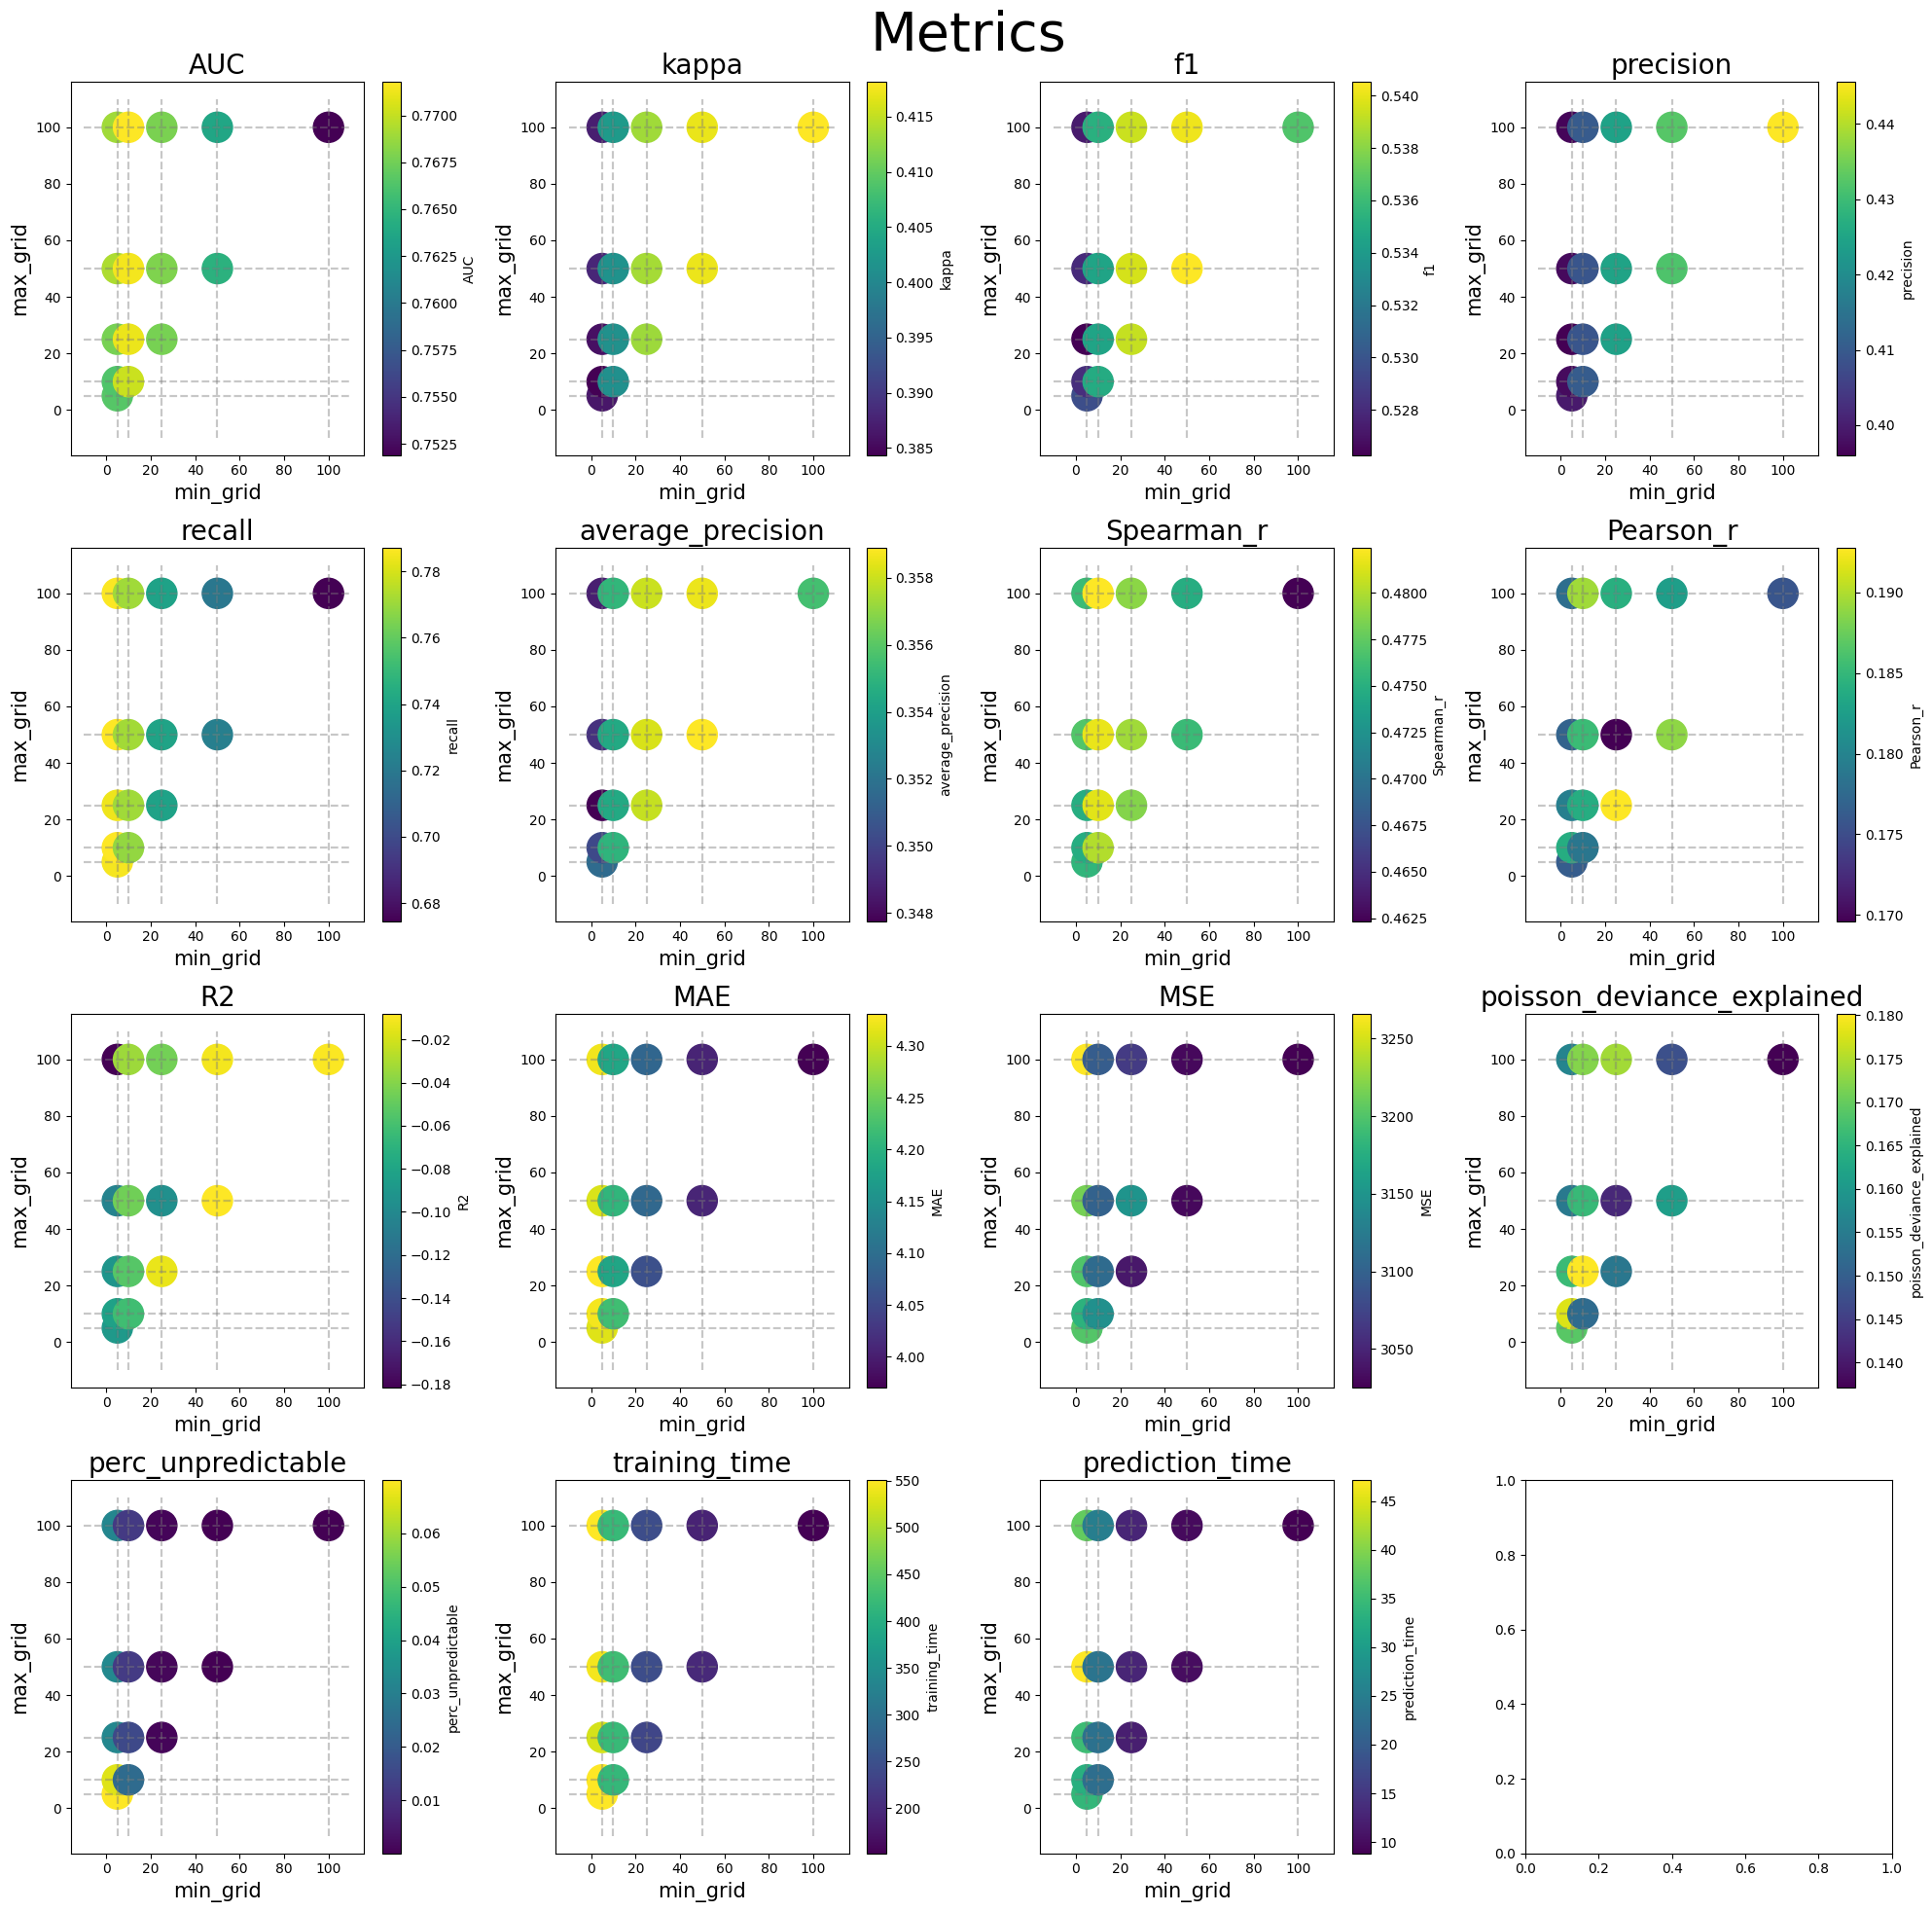

In [115]:
# plotting
vars_ = ['AUC', 'kappa', 'f1', 'precision',
       'recall', 'average_precision', 'Spearman_r', 'Pearson_r', 'R2', 'MAE',
       'MSE', 'poisson_deviance_explained', 'perc_unpredictable',
       'training_time', 'prediction_time']

column = 4
best_gridding = find_the_best_gridding(len(vars_), column=column)
fig, ax = plt.subplots(best_gridding, column, figsize=(20, 5*best_gridding))
plt.suptitle('Metrics',fontsize=40)

row = 0
col = 0

for metric in vars_:
    
    plt.sca(ax[row, col])
    for ii, xx in enumerate(set(list(min_grids) + list(max_grids))):
        for yy in list(set(list(min_grids) + list(max_grids))):
            plt.plot([xx, xx],[-10, 110], linestyle='--', c='tab:grey', alpha=0.1)
            plt.plot([-10, 110], [yy, yy],linestyle='--', c='tab:grey', alpha=0.1)
        
    p = plt.scatter(
        mean_metrics_df.min_grid,
        mean_metrics_df.max_grid,
        c=mean_metrics_df[metric],s=500
    )
        
    plt.colorbar(p, label=metric)
    plt.title(metric, fontsize=20)
    plt.xlabel('min_grid', fontsize=15)
    plt.ylabel('max_grid', fontsize=15)
    
    col += 1
    if col > column-1:
        col = 0
        row += 1
    

plt.tight_layout()
plt.show()




## Conclusion

Seems like there is a trade-off between running time (training and prediction) and model performance. min_grid 10 seems to be a sweet spot for AUC and Spearman's r, but doesn't make much difference in this case. The computational times increase rapidly with finer resolution. Generally speaking, larger stixel makes sense if the task is not for extremely fine-scale resolution.

In [117]:
from watermark import watermark
print(watermark())
print(watermark(packages="stemflow,numpy,scipy,pandas,xgboost,tqdm,matplotlib,h3pandas,geopandas,sklearn"))


Last updated: 2023-09-22T14:12:32.378092+08:00

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 8.14.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

stemflow  : 1.0.1
numpy     : 1.24.3
scipy     : 1.10.1
pandas    : 2.0.3
xgboost   : 1.7.6
tqdm      : 4.65.0
matplotlib: 3.7.1
h3pandas  : 0.2.4
geopandas : 0.11.1
sklearn   : 0.0

